In [1]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')

### dataframe

In [2]:
df = pd.read_csv(data_path / 'historical_data.csv')

In [3]:
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

### initial data processing 

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [6]:
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

#### handeling nulls

In [7]:
def nulls_data(df): 

    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    percent_null = (null_counts/len(df)) * 100
    null_table = pd.DataFrame({'column': null_counts.index, 'data type': df[null_counts.index].dtypes, 'number of nulls': null_counts.values, 
                               'precent null': percent_null.values})
    null_table = null_table.sort_values(by='precent null', ascending=False).reset_index(drop=True)

    return null_table

In [8]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,total_onshift_dashers,float64,16262,8.236927
1,total_busy_dashers,float64,16262,8.236927
2,total_outstanding_orders,float64,16262,8.236927
3,store_primary_category,object,4760,2.411006
4,order_protocol,float64,995,0.503981
5,market_id,float64,987,0.499929
6,estimated_store_to_consumer_driving_duration,float64,526,0.266426
7,actual_delivery_time,datetime64[ns],7,0.003546


In [ ]:
# checking if the null values in these columns occurr all on the same rows
df.loc[df['total_onshift_dashers'].isnull() & df['total_busy_dashers'].isnull() & df['total_outstanding_orders'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,225,350,NaN,NaN,NaN,251,671.0
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,185,675,NaN,NaN,NaN,251,893.0
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,650,650,NaN,NaN,NaN,251,479.0
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,225,700,NaN,NaN,NaN,251,1104.0
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,185,185,NaN,NaN,NaN,251,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,indian,2.0,3,1792,3,163,1177,NaN,NaN,NaN,251,725.0
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,indian,2.0,8,2923,5,50,1199,NaN,NaN,NaN,251,683.0
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,indian,2.0,3,3297,3,799,1299,NaN,NaN,NaN,251,725.0
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,indian,2.0,4,2776,4,179,1099,NaN,NaN,NaN,251,820.0


In [ ]:
dropped_df = df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'])

In [ ]:
# there is no overlap between the nulls in those three categories and the nulls in other categories
nulls_data(dropped_df)

,column,data type,number of nulls,precent null
0,store_primary_category,object,4760,2.411006
1,order_protocol,float64,995,0.503981
2,market_id,float64,987,0.499929
3,estimated_store_to_consumer_driving_duration,float64,526,0.266426
4,actual_delivery_time,datetime64[ns],7,0.003546


In [9]:
marketid_mode = df.dropna(subset=['store_id', 'market_id']).groupby('store_id')['market_id'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [10]:
marketid_mode

store_id
1       3.0
2       1.0
3       3.0
4       1.0
5       6.0
       ... 
6983    1.0
6984    6.0
6985    1.0
6986    4.0
6987    3.0
Name: market_id, Length: 6740, dtype: float64

In [11]:
df['market_id'] = df['market_id'].fillna(df['store_id'].map(marketid_mode))

In [12]:
df = df.dropna(subset=['market_id'])

In [13]:
category_mode = df.dropna(subset=['store_id', 'store_primary_category']).groupby('store_id')['store_primary_category'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [14]:
df.loc[:, 'store_primary_category'] = df['store_primary_category'].fillna(df['store_id'].map(category_mode))

In [15]:
nulls_data(df)

,column,data type,number of nulls,precent null
0,total_onshift_dashers,float64,16261,8.236546
1,total_busy_dashers,float64,16261,8.236546
2,total_outstanding_orders,float64,16261,8.236546
3,order_protocol,float64,992,0.502469
4,store_primary_category,object,866,0.438648
5,estimated_store_to_consumer_driving_duration,float64,526,0.266430
6,actual_delivery_time,datetime64[ns],7,0.003546


In [ ]:
imputer = KNNImputer(n_neighbors=5)

In [ ]:
df.loc[:, ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_protocol', 'estimated_store_to_consumer_driving_duration']] = imputer.fit_transform(df[['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'order_protocol', 'estimated_store_to_consumer_driving_duration']])

In [ ]:
df = df.dropna(subset=['actual_delivery_time'])

In [ ]:
nulls_data(df)

,column,data type,number of nulls,precent null


In [ ]:
df2 = pd.read_csv('historical_data copy.csv')

In [ ]:
category_mode = df2.dropna(subset=['store_id', 'store_primary_category']).groupby('store_id')['store_primary_category'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [ ]:
df2.loc[:, 'store_primary_category'] = df2['store_primary_category'].fillna(df2['store_id'].map(category_mode))

In [ ]:
category_mode = df2.dropna(subset=['market_id', 'store_primary_category']).groupby('market_id')['store_primary_category'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [ ]:
df2.loc[:, 'store_primary_category'] = df2['store_primary_category'].fillna(df2['market_id'].map(category_mode))

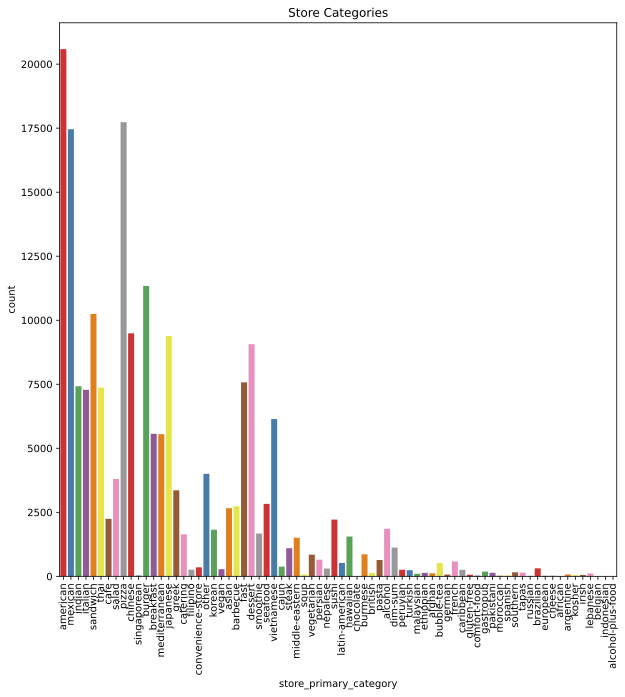

In [ ]:
plt.figure(figsize=(10,10))

sns.countplot(x='store_primary_category', data=df2, palette='Set1')
plt.title('Store Categories')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(df2['store_primary_category'].value_counts(normalize=True))

store_primary_category
american             0.104266
pizza                0.089826
mexican              0.088438
burger               0.057419
sandwich             0.051893
                       ...   
african              0.000051
belgian              0.000010
indonesian           0.000010
chocolate            0.000005
alcohol-plus-food    0.000005
Name: proportion, Length: 74, dtype: float64


In [16]:
df['created_at'].dt.year.value_counts()

created_at
2015    197424
2014         1
Name: count, dtype: int64

In [17]:
df['created_at'].dt.month.value_counts()

created_at
2     128942
1      68482
10         1
Name: count, dtype: int64

In [18]:
# this is seems wrong. Check for other date descrpencies
df[df['created_at'].dt.month == 10]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0


In [ ]:
day = df['created_at'].dt.day_of_week.copy()

In [ ]:
df.loc[:, 'day'] = day

In [ ]:
df['day'].value_counts()

day
5    34541
6    33612
4    27875
0    27402
3    25673
2    24254
1    24061
Name: count, dtype: int64

In [ ]:
hour = df['created_at'].dt.hour.copy()

In [ ]:
df.loc[:, 'hour'] = hour

In [ ]:
df['hour']

0         22
1         21
2         20
3         21
4          2
          ..
197423     0
197424     0
197425     4
197426    18
197427    19
Name: hour, Length: 197418, dtype: int32

In [ ]:
df['actual_delivery_time'].dt.year.value_counts()

actual_delivery_time
2015    197418
Name: count, dtype: int64

In [ ]:
df['actual_delivery_time'].dt.month.value_counts()

actual_delivery_time
2    129188
1     68230
Name: count, dtype: int64

In [ ]:
df['created_at'].dt.year.value_counts()

created_at
2015    197417
2014         1
Name: count, dtype: int64

In [ ]:
df['created_at'].dt.month.value_counts()

created_at
2     128935
1      68482
10         1
Name: count, dtype: int64

In [ ]:
df['hour'].value_counts()

hour
2     36973
1     28187
3     27067
20    15560
4     15250
19    13541
0     12669
21    11464
22     8821
23     8161
5      7096
18     5100
17     3413
16     2109
6      1416
15      538
14       40
7        11
8         2
Name: count, dtype: int64

In [ ]:
# df['precent_busy'] = (df['total_busy_dashers']/df['total_onshift_dashers']) * 100

In [ ]:
# np.isinf(df['precent_busy']).sum().sum()

np.int64(39)

In [ ]:
#df['precent_busy'].isna().sum().sum()

np.int64(3576)

In [ ]:
#df['precent_busy'] = df['precent_busy'].replace([np.inf, -np.inf], 0)

In [ ]:
#df['precent_busy'].isna().sum().sum()

np.int64(3576)

In [ ]:
#df['precent_busy'] = df['precent_busy'].fillna(0)

In [ ]:
#df.loc[df['precent_busy'].isna()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_duration,day,hour,precent_busy


In [ ]:
#(df['total_onshift_dashers'] == 0).sum().sum()

np.int64(3615)

In [ ]:
dasher_order_difference = (df['total_onshift_dashers'] - df['total_outstanding_orders']).copy()

In [ ]:
df['dasher_order_difference'] = dasher_order_difference

In [ ]:
np.isinf(df['dasher_order_difference']).sum().sum()

np.int64(0)

In [ ]:
inf_values = np.isinf(df)

In [ ]:
df.isna().sum().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197418 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197418 non-null  float64       
 1   created_at                                    197418 non-null  datetime64[ns]
 2   actual_delivery_time                          197418 non-null  datetime64[ns]
 3   store_id                                      197418 non-null  int64         
 4   store_primary_category                        197418 non-null  float64       
 5   order_protocol                                197418 non-null  float64       
 6   total_items                                   197418 non-null  int64         
 7   subtotal                                      197418 non-null  int64         
 8   num_distinct_items                            197418 non-nu

In [ ]:
sns.pairplot(df.drop(columns=['created_at', 'actual_delivery_time']))

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

: 

In [ ]:
heatmap_corr = df.corr()

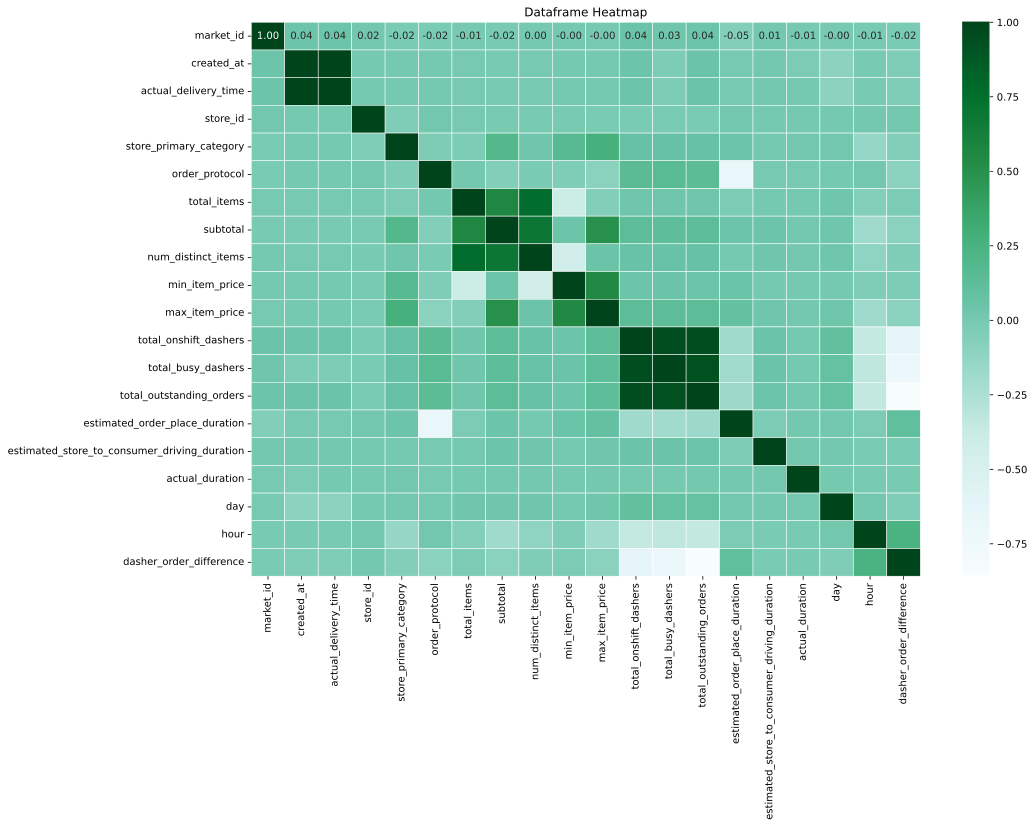

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(heatmap_corr, annot=True, fmt='.2f', cmap='BuGn', linewidths=0.5)
plt.title('Dataframe Heatmap')
plt.show()

In [ ]:
mask = (heatmap_corr.abs() > 0.8) & (heatmap_corr != 1)

In [ ]:
columns_corr = mask.any(axis=0)

In [ ]:
columns_corr

market_id                                       False
created_at                                       True
actual_delivery_time                             True
store_id                                        False
store_primary_category                          False
order_protocol                                  False
total_items                                     False
subtotal                                        False
num_distinct_items                              False
min_item_price                                  False
max_item_price                                  False
total_onshift_dashers                            True
total_busy_dashers                               True
total_outstanding_orders                         True
estimated_order_place_duration                  False
estimated_store_to_consumer_driving_duration    False
actual_duration                                 False
day                                             False
hour                        

In [ ]:
corr_m = heatmap_corr[heatmap_corr.abs() > 0.7]

In [ ]:
corr_pairs = corr_m.stack().reset_index()

In [ ]:
corr_pairs.columns = ['column1', 'column2', 'correlation']

In [ ]:
corr_pairs.loc[corr_pairs['column1'] == corr_pairs['column2']]

,column1,column2,correlation
0,market_id,market_id,1.0
1,created_at,created_at,1.0
4,actual_delivery_time,actual_delivery_time,1.0
5,store_id,store_id,1.0
6,store_primary_category,store_primary_category,1.0
7,order_protocol,order_protocol,1.0
8,total_items,total_items,1.0
10,subtotal,subtotal,1.0
12,num_distinct_items,num_distinct_items,1.0
13,min_item_price,min_item_price,1.0


In [ ]:
corr_pairs = corr_pairs.drop(corr_pairs.loc[corr_pairs['column1'] == corr_pairs['column2']].index)

In [ ]:
corr_pairs.drop_duplicates(subset='correlation')

,column1,column2,correlation
2,created_at,actual_delivery_time,0.999616
9,total_items,num_distinct_items,0.763906
16,total_onshift_dashers,total_busy_dashers,0.944223
17,total_onshift_dashers,total_outstanding_orders,0.936124
20,total_busy_dashers,total_outstanding_orders,0.933213
24,total_outstanding_orders,dasher_order_difference,-0.858528


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197418 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197418 non-null  float64       
 1   created_at                                    197418 non-null  datetime64[ns]
 2   actual_delivery_time                          197418 non-null  datetime64[ns]
 3   store_id                                      197418 non-null  int64         
 4   store_primary_category                        197418 non-null  float64       
 5   order_protocol                                197418 non-null  float64       
 6   total_items                                   197418 non-null  int64         
 7   subtotal                                      197418 non-null  int64         
 8   num_distinct_items                            197418 non-nu

In [ ]:
X = df.drop(columns=['created_at', 'actual_delivery_time', 'num_distinct_items', 'total_busy_dashers', 'total_outstanding_orders', 'actual_duration'])
y = df['actual_duration']

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

### linear regression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(xtrain,ytrain)

LinearRegression()

In [ ]:
ypreds = lr.predict(xtest)

In [ ]:
r2_score(ytest, ypreds)

0.12125174617858525

### polynomial regression

In [ ]:
poly = PolynomialFeatures(2)

In [ ]:
xtrain_poly = poly.fit_transform(xtrain)

In [ ]:
xtest_poly = poly.transform(xtest)

In [ ]:
lr_poly = LinearRegression()

In [ ]:
lr_poly.fit(xtrain_poly, ytrain)

LinearRegression()

In [ ]:
ypreds = lr_poly.predict(xtest_poly)

In [ ]:
r2_score(ypreds, ytest)

-0.6511056346021964

### random forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
rf.fit(xtrain, ytrain)

RandomForestRegressor(random_state=42)

In [ ]:
ypreds = rf.predict(xtest)

In [ ]:
r2_score(ypreds, ytest)

-0.013274249600694121

In [ ]:
# rf_param = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 20],
#     'min_samples_leaf': [1,3,5]
# }

rf_param = {
    'n_estimators': [20, 30, 50],
    'max_depth': [20, 30, 50],
    'min_samples_leaf': [5,7,10]
}

rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_param, n_iter=10, cv=5, n_jobs=1, random_state=42)

In [ ]:
rf_search.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': [20, 30, 50],
                                        'min_samples_leaf': [5, 7, 10],
                                        'n_estimators': [20, 30, 50]},
                   random_state=42)

In [ ]:
rf_best_parm = rf_search.best_params_
rf_best_model = rf_search.best_estimator_

In [ ]:
rf_best_preds = rf_best_model.predict(xtest)

In [ ]:
r2_score(rf_best_preds, ytest)

-0.11894785387187978

In [ ]:
rf_param = {
    'n_estimators': [20, 30, 50],
    'max_depth': [20, 30, 50],
    'min_samples_leaf': [1,3,5]
}